<a href="https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Training_ALIGNN_model_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Table of contents

1. Installing [ALIGNN](https://github.com/usnistgov/alignn)
2. Example training for regression on 50 materials,
3. Using more than 70 pre-trained models to make fast predictions
4. ALIGNN-FF Ase Calculator: predict energy/forces, optimized strcture, EV curves and phonons
5. Train ALIGNN-FF on a new dataset
6. Additional examples
7. Add ALIGNN-results to the JARVIS-Leaderboard

Author: Kamal Choudhary (kamal.choudhary@nist.gov)

## ALIGNN model ref.: https://www.nature.com/articles/s41524-021-00650-1
## ALIGNN-FF ref.: https://pubs.rsc.org/en/content/articlehtml/2023/dd/d2dd00096b

# 1. Installation

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


Bases on nvcc version, corresponding gpu version of dgl will be needed.

In [2]:
%%time
!pip install --pre dgl -f https://data.dgl.ai/wheels/cu118/repo.html
!pip install --pre dglgo -f https://data.dgl.ai/wheels-test/repo.html
!pip install alignn

Looking in links: https://data.dgl.ai/wheels/cu118/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 MB 7.5 MB/s eta 0:00:00
Looking in links: https://data.dgl.ai/wheels-test/repo.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.5/63.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.3/105.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.2/45.2 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 50.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.3/41.3 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 106.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.6/485.6 kB 42.5 MB/s eta 0:0

CPU times: user 525 ms, sys: 89.1 ms, total: 614 ms
Wall time: 1min 14s


In [3]:
import os
!pwd
os.chdir('/content')
# Clone ALIGNN repo to get example folder
if not os.path.exists('alignn'):
  !git clone https://github.com/usnistgov/alignn.git

os.chdir('alignn')
# Install using setup.py in case pip didn't work
# !python setup.py develop

#!pip install dgl-cu111 # Colab has cuda 11.1

/content
Cloning into 'alignn'...
remote: Enumerating objects: 3969, done.
remote: Counting objects: 100% (1563/1563), done.
remote: Compressing objects: 100% (532/532), done.
remote: Total 3969 (delta 1131), reused 1291 (delta 984), pack-reused 2406
Receiving objects: 100% (3969/3969), 154.28 MiB | 14.65 MiB/s, done.
Resolving deltas: 100% (2307/2307), done.


Example folder with id_prop.csv and 'POSCAR files.'

In [4]:
!ls "alignn/examples/sample_data"

config_example.json	  POSCAR-JVASP-64045.vasp  POSCAR-JVASP-86097.vasp
id_prop.csv		  POSCAR-JVASP-64240.vasp  POSCAR-JVASP-86205.vasp
POSCAR-JVASP-107772.vasp  POSCAR-JVASP-64377.vasp  POSCAR-JVASP-86436.vasp
POSCAR-JVASP-10.vasp	  POSCAR-JVASP-64584.vasp  POSCAR-JVASP-86726.vasp
POSCAR-JVASP-13526.vasp   POSCAR-JVASP-64664.vasp  POSCAR-JVASP-86968.vasp
POSCAR-JVASP-1372.vasp	  POSCAR-JVASP-64719.vasp  POSCAR-JVASP-89025.vasp
POSCAR-JVASP-14014.vasp   POSCAR-JVASP-64906.vasp  POSCAR-JVASP-89265.vasp
POSCAR-JVASP-14441.vasp   POSCAR-JVASP-65062.vasp  POSCAR-JVASP-90228.vasp
POSCAR-JVASP-14873.vasp   POSCAR-JVASP-65101.vasp  POSCAR-JVASP-90532.vasp
POSCAR-JVASP-15345.vasp   POSCAR-JVASP-655.vasp    POSCAR-JVASP-90856.vasp
POSCAR-JVASP-1996.vasp	  POSCAR-JVASP-676.vasp    POSCAR-JVASP-97378.vasp
POSCAR-JVASP-21210.vasp   POSCAR-JVASP-76308.vasp  POSCAR-JVASP-97499.vasp
POSCAR-JVASP-22556.vasp   POSCAR-JVASP-76309.vasp  POSCAR-JVASP-97570.vasp
POSCAR-JVASP-27901.vasp   POSCAR-JVASP-76312.

# 2. Example regression task

# 50 materials and their bandgap data generated with the script [generate_sample_data_reg.py](https://github.com/usnistgov/alignn/blob/main/alignn/examples/sample_data/scripts/generate_sample_data_reg.py)

# Train a model for 3 epochs and batch size of 2. Other parameters are provided in `config_example.json` file.

#Note: For an involved training, use higher batch size such as 16 and epochs such as 300.

Command line train_folder.py is used below.

In [5]:
import time
t1=time.time()
!train_folder.py --root_dir "alignn/examples/sample_data" --epochs 3 --batch_size 2 --config "alignn/examples/sample_data/config_example.json" --output_dir=temp
t2=time.time()
print ('Time in s',t2-t1)

DGL backend not selected or invalid.  Assuming PyTorch for now.
Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)
MAX val: 6.149
MIN val: 0.0
MAD: 1.0520696
Baseline MAE: 2.3805500000000004
data range 4.907 0.0
100% 40/40 [00:03<00:00, 11.14it/s]
df                                                 atoms  ... target
0   {'lattice_mat': [[3.566933224304235, 0.0, -0.0...  ...  0.000
1   {'lattice_mat': [[4.089078911208881, 0.0, 0.0]...  ...  0.000
2   {'lattice_mat': [[-1.833590720595598, 1.833590...  ...  0.000
3   {'lattice_mat': [[7.2963518353359165, 0.0, 0.0...  ...  0.472
4   {'lattice_mat': [[1.6777483798834445, -2.90594...  ...  0.000
5   {'lattice_mat': [[4.157436115454804, -0.0, 0.0...  ...  0.000
6   {'lattice_mat': [[0.0, 5.1858714074842, 5.1858...  ...  0.000
7   {'lattice_mat': [[3.790914410660539, -0.0, 0.0...  ...  0.000
8   {

In [6]:
!ls

alignn	LICENSE.rst  pyproject.toml  README.md	setup.py  temp


The model produces *.pt files which are the trained models.

In [7]:
!ls temp

checkpoint_2.pt		 mad
checkpoint_3.pt		 prediction_results_test_set.csv
config.json		 prediction_results_train_set.csv
history_train.json	 test_data_data_range
history_val.json	 train_data_data_range
ids_train_val_test.json  val_data_data_range


We can load a trained model above as the following:

In [8]:
from alignn.models.alignn import ALIGNN, ALIGNNConfig
import torch
output_features =  1
filename = 'temp/checkpoint_3.pt'
device = "cpu"
if torch.cuda.is_available():
    device = torch.device("cuda")
model = ALIGNN(ALIGNNConfig(name="alignn", output_features=output_features))
model.load_state_dict(torch.load(filename, map_location=device)["model"])
model.eval()

ALIGNN(
  (atom_embedding): MLPLayer(
    (layer): Sequential(
      (0): Linear(in_features=92, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU()
    )
  )
  (edge_embedding): Sequential(
    (0): RBFExpansion()
    (1): MLPLayer(
      (layer): Sequential(
        (0): Linear(in_features=80, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
    )
    (2): MLPLayer(
      (layer): Sequential(
        (0): Linear(in_features=64, out_features=256, bias=True)
        (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU()
      )
    )
  )
  (angle_embedding): Sequential(
    (0): RBFExpansion()
    (1): MLPLayer(
      (layer): Sequential(
        (0): Linear(in_features=40, out_features=64, bias=True)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.

Now, we can build graph for a given structure and make a prediction as follows:

In [9]:
from jarvis.core.atoms import Atoms
from alignn.graphs import Graph
cutoff = 8.0
model=model.to(device)
max_neighbors = 12
atoms = Atoms.from_poscar('alignn/examples/sample_data/POSCAR-JVASP-10.vasp')
g, lg = Graph.atom_dgl_multigraph(
    atoms, cutoff=float(cutoff), max_neighbors=max_neighbors,
)
out_data = (
    model([g.to(device), lg.to(device)])
    .detach()
    .cpu()
    .numpy()
    .flatten()
    .tolist()
)
print ('output', out_data[0])

output 3.7358312606811523


We have already trained multiple models on several large datasets which can be used with the pretrained.py executable.

# 3. Using more than 70 pre-trained models to make fast predictions

Use pretrained models such as models trained on JARVIS-DFT, QM9, Materials project, hMOF etc. databases. The models are downloaded from figshare. See the list here: https://github.com/usnistgov/alignn/blob/main/alignn/pretrained.py#L28

In [10]:
!pretrained.py -h

usage: pretrained.py
       [-h]
       [--model_name MODEL_NAME]
       [--file_format FILE_FORMAT]
       [--file_path FILE_PATH]
       [--cutoff CUTOFF]
       [--max_neighbors MAX_NEIGHBORS]

Atomistic
Line Graph
Neural
Network
Pretrained
Models

options:
  -h, --help
    show this
    help
    message and
    exit
  --model_name MODEL_NAME
    Choose a
    model from
    these 44 mo
    dels:jv_for
    mation_ener
    gy_peratom_
    alignn, jv_
    optb88vdw_t
    otal_energy
    _alignn, jv
    _optb88vdw_
    bandgap_ali
    gnn, jv_mbj
    _bandgap_al
    ignn, jv_sp
    illage_alig
    nn, jv_slme
    _alignn, jv
    _bulk_modul
    us_kv_align
    n, jv_shear
    _modulus_gv
    _alignn,
    jv_n-Seebec
    k_alignn,
    jv_n-powerf
    act_alignn,
    jv_magmom_o
    szicar_alig
    nn, jv_kpoi
    nt_length_u
    nit_alignn,
    jv_avg_elec
    _mass_align
    n, jv_avg_h
    ole_mass_al
    ignn, jv_ep
    sx_alignn, 
    jv_mepsx_al
    ignn, jv_ma
    x_efg_align
    n

In [11]:
!pretrained.py --model_name jv_formation_energy_peratom_alignn --file_format poscar --file_path alignn/examples/sample_data/POSCAR-JVASP-10.vasp

100% 47.5M/47.5M [00:03<00:00, 11.9MiB/s]
Using chk file jv_formation_energy_peratom_alignn/checkpoint_300.pt from  ['jv_formation_energy_peratom_alignn/checkpoint_300.pt']
Path /usr/local/bin/jv_formation_energy_peratom_alignn.zip
Config /content/alignn/jv_formation_energy_peratom_alignn/config.json
Predicted value: jv_formation_energy_peratom_alignn alignn/examples/sample_data/POSCAR-JVASP-10.vasp [-0.7033944725990295]


#  4. ALIGNN-FF Ase Calculator: predict energy/forces, optimized strcture, EV curves and phonons


ASE Calculator wrapper for ALIGNN-FF

In [12]:
from alignn.ff.ff import AlignnAtomwiseCalculator,default_path,wt10_path
model_path = wt10_path() #default_path()
calc = AlignnAtomwiseCalculator(path=model_path)

dir_path /content/alignn/alignn/ff/alignnff_wt10


100%|██████████| 15.0M/15.0M [00:01<00:00, 8.78MiB/s]


model_path /content/alignn/alignn/ff/alignnff_wt10


In [13]:
from ase import Atom, Atoms
import numpy as np
import matplotlib.pyplot as plt

lattice_params = np.linspace(3.5, 3.8)
fcc_energies = []
ready = True
for a in lattice_params:
    atoms = Atoms([Atom('Cu', (0, 0, 0))],
                  cell=0.5 * a * np.array([[1.0, 1.0, 0.0],
                                           [0.0, 1.0, 1.0],
                                           [1.0, 0.0, 1.0]]),
                 pbc=True)

    atoms.set_tags(np.ones(len(atoms)))

    atoms.calc = calc

    e = atoms.get_potential_energy()
    fcc_energies.append(e)

Check if EV curves are smooth

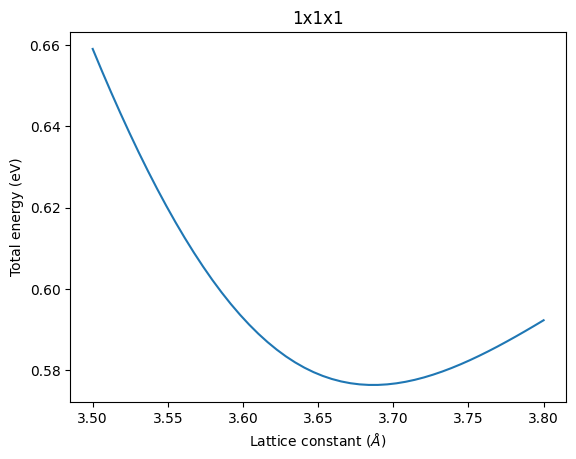

In [14]:
#Reference: https://gist.github.com/jkitchin/e8ab20750b1d516cb8761f519f2c53d5
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(lattice_params, fcc_energies)
plt.title('1x1x1')
plt.xlabel('Lattice constant ($\AA$)')
plt.ylabel('Total energy (eV)')
plt.show()

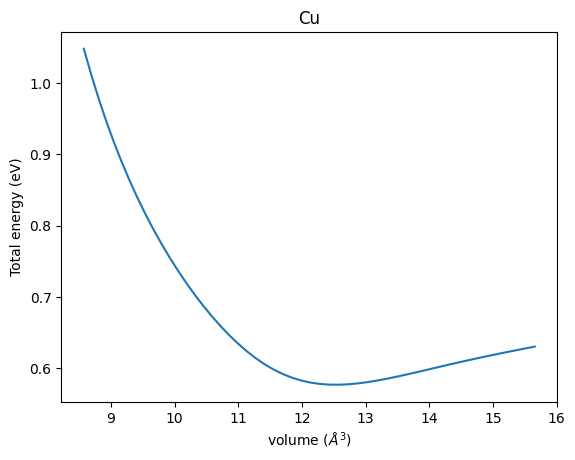

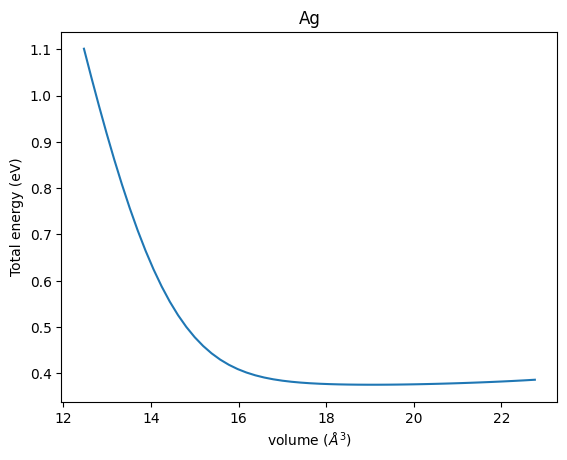

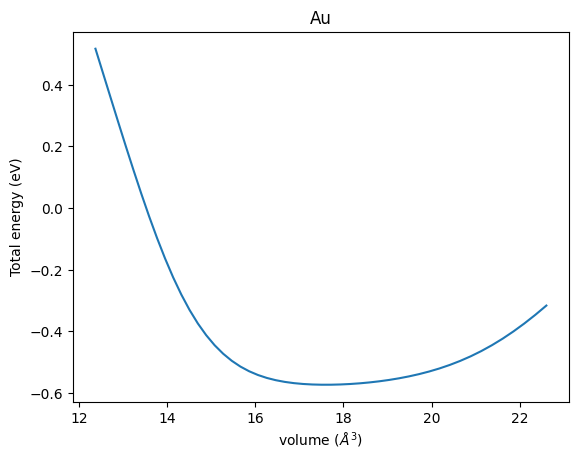

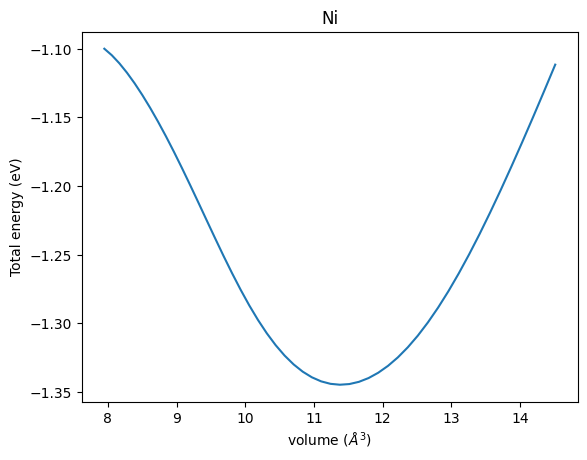

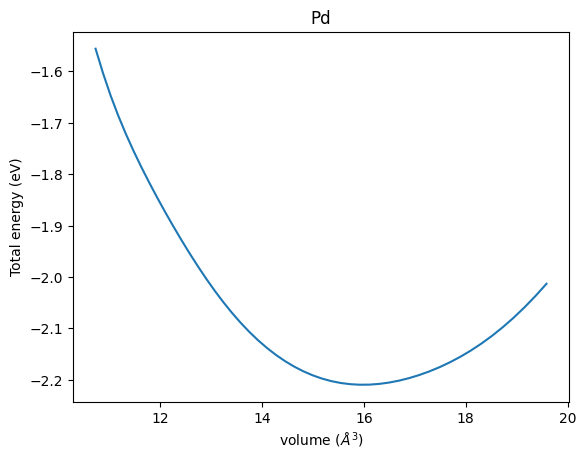

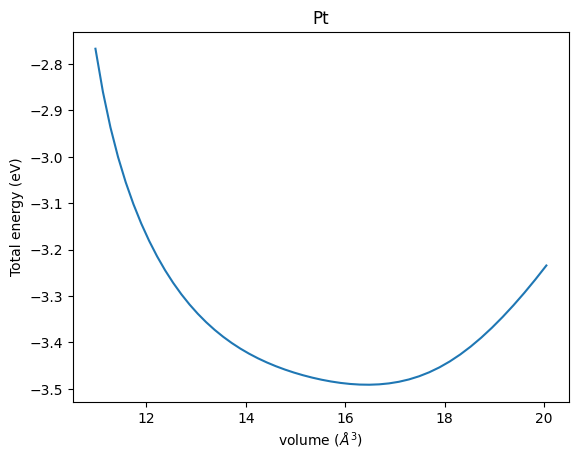

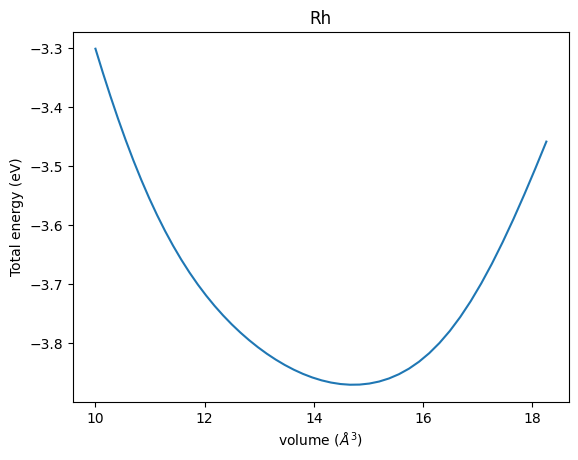

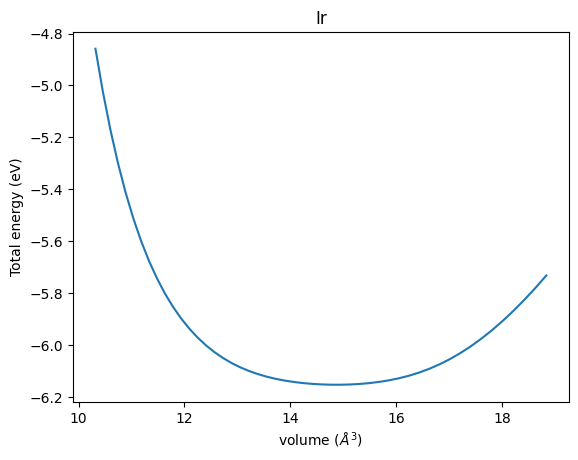

In [15]:
from ase import data
for metal in ['Cu', 'Ag', 'Au', 'Ni', 'Pd', 'Pt', 'Rh', 'Ir']:
    a = data.reference_states[data.atomic_numbers[metal]]['a']
    LC = np.linspace(0.9 * a, 1.1 * a)
    vols, energies = [], []
    for a in LC:
        atoms = Atoms([Atom(metal, (0, 0, 0))],
                      cell=0.5 * a * np.array([[1.0, 1.0, 0.0],
                                               [0.0, 1.0, 1.0],
                                               [1.0, 0.0, 1.0]]),
                     pbc=True)

        atoms.set_tags(np.ones(len(atoms)))

        atoms.calc = calc

        e = atoms.get_potential_energy()
        vols += [atoms.get_volume()]
        energies.append(e)
    plt.figure()
    plt.plot(vols, energies)
    plt.title(metal)
    plt.xlabel('volume ($\AA^3$)')
    plt.ylabel('Total energy (eV)');

Using ALIGNN-FF pretrained model to get unrelaxed energy and relaxed structure

Check phonons

In [39]:
pip install -q phonopy

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


dir_path /content/alignn/alignn/ff/alignnff_fd
model_path /content/alignn/alignn/ff/alignnff_fd


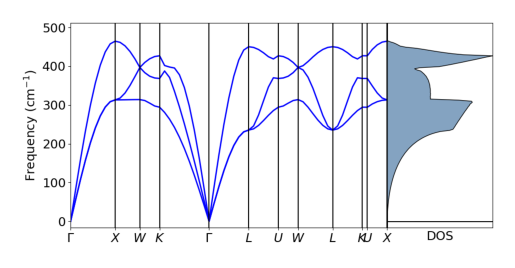

In [40]:
%%time
from alignn.ff.ff import phonons
from alignn.ff.ff import AlignnAtomwiseCalculator,default_path,wt10_path,alignnff_fmult,fd_path,ForceField
from jarvis.core.atoms import ase_to_atoms
from ase import Atom, Atoms as AseAtoms
a = 3.597
atoms = AseAtoms([Atom('Cu', (0, 0, 0))],
              cell=0.5 * a * np.array([[1.0, 1.0, 0.0],
                                        [0.0, 1.0, 1.0],
                                        [1.0, 0.0, 1.0]]),
              pbc=True)
ph_path=fd_path()
ph=phonons(model_path=ph_path, phonopy_bands_figname="phonopy_bands.png", atoms=ase_to_atoms(atoms))
%matplotlib inline
plt.axis('off')
plt.imshow(plt.imread("phonopy_bands.png"))
plt.show()

In [16]:
!run_alignn_ff.py --file_path alignn/examples/sample_data/POSCAR-JVASP-10.vasp --task="unrelaxed_energy"

dir_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_fmult
100% 10.1M/10.1M [00:01<00:00, 7.07MiB/s]
model_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_fmult
Energy(eV) (-11.688049077987671, array([[ 2.7939677e-09,  2.5145710e-08,  5.0291419e-08],
       [ 3.7252903e-09,  7.0314854e-08,  6.5683164e-03],
       [-4.1909516e-09, -7.3807314e-08, -6.5683722e-03]], dtype=float32))


In [17]:
!run_alignn_ff.py --file_path alignn/examples/sample_data/POSCAR-JVASP-10.vasp --task="optimize"

dir_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_fmult
model_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_fmult
OPTIMIZATION
a= 1.678 Ang b= 2.906 Ang c= 6.221 Ang Volume= 60.658 amu/a3 PE=-11.68805 eV KE= 0.00000 eV T= 0.000 K 
a= 1.684 Ang b= 2.917 Ang c= 6.237 Ang Volume= 61.275 amu/a3 PE=-11.69072 eV KE= 0.00000 eV T= 0.000 K 
initial struct:
VSe2
1.0
1.6777483798834445 -2.9059452409270157 -1.1e-15
1.6777483798834438 2.9059452409270126 -7e-16
-6.5e-15 -8e-16 6.220805465667012
V Se
1 2
Cartesian
0.0 0.0 0.0
1.67775 -0.9686519372999812 4.6529213966213625
1.67775 0.9686519372999813 1.5678886033786343

final struct:
VSe2
1.0
1.6840115504389588 -2.916793199150111 1.0814981162131699e-07
1.6840115478311415 2.916793197644484 -1.1148343199253782e-07
-6.180251681127945e-09 -2.3508627592741866e-07 6.237406461549268
V Se
1 2
Cartesian
2.8043977681794246e-11 2.5239577099270287e-10 5.042562700538078e-10
1.6840131711490116 -0.9722681121622446 4.66540419154428

In [18]:
!run_alignn_ff.py --file_path alignn/examples/sample_data/POSCAR-JVASP-10.vasp --task="ev_curve"

dir_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_fmult
model_path /usr/local/lib/python3.10/dist-packages/alignn/ff/alignnff_fmult
E [-11.49867153 -11.58296728 -11.64178276 -11.67460728 -11.68170691
 -11.68804908 -11.68475461 -11.67712784 -11.68052387 -11.64295506]
V [52.00698610745743, 53.66666028373519, 55.3612736919685, 57.09119028249023, 58.85677400563329, 60.6583888117305, 62.496398651114745, 64.3711674741189, 66.28305923107584, 68.23243787231843]
terminate called without an active exception

LIBXSMM_VERSION: main-1.17-3659 (25693771)
LIBXSMM_TARGET: hsw [Intel(R) Xeon(R) CPU @ 2.20GHz]
Registry and code: 13 MB
Command: /usr/bin/python3 /usr/local/bin/run_alignn_ff.py --file_path alignn/examples/sample_data/POSCAR-JVASP-10.vasp --task=ev_curve 
Uptime: 3.971156 s


# 5. Train ALIGNN-FF on a new dataset

For a detailed example, check outthis notebook: https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/Train_ALIGNNFF_Mlearn.ipynb

In [19]:
!train_folder_ff.py --root_dir "alignn/examples/sample_data_ff" --config "alignn/examples/sample_data_ff/config_example_atomwise.json" --output_dir=temp

len dataset 50
MAX val: -24.52653862
MIN val: -42.04135008
MAD: 7.884625411000001
Baseline MAE: 11.991239256250003
data range -24.52653862 -42.04135008
100% 40/40 [00:00<00:00, 57.72it/s]
df        target  ...    jid
0  -29.313096  ...  15607
1  -29.312862  ...  15607
2  -29.312159  ...  15607
3  -29.312429  ...  15607
4  -29.312428  ...  15607
5  -29.312791  ...  15607
6  -29.311952  ...  15607
7  -29.311899  ...  15607
8  -29.312800  ...  15607
9  -42.041350  ...  15608
10 -42.002227  ...  15608
11 -42.016896  ...  15608
12 -42.002229  ...  15608
13 -42.016896  ...  15608
14 -42.019225  ...  15608
15 -42.032726  ...  15608
16 -42.029257  ...  15608
17 -42.029256  ...  15608
18 -42.030165  ...  15608
19 -42.030166  ...  15608
20 -42.030172  ...  15608
21 -42.030172  ...  15608
22 -42.040889  ...  15608
23 -42.040889  ...  15608
24 -42.040710  ...  15608
25 -42.040710  ...  15608
26 -42.039555  ...  15608
27 -42.039553  ...  15608
28 -42.040184  ...  15608
29 -42.040186  ...  15608
30 

The generated model is saved as best_model.pt

In [20]:
!ls -altr temp

total 111116
-rw-r--r-- 1 root root 48661045 Jul 26 02:35 checkpoint_2.pt
-rw-r--r-- 1 root root 48660981 Jul 26 02:35 checkpoint_3.pt
-rw-r--r-- 1 root root      243 Jul 26 02:35 prediction_results_test_set.csv
-rw-r--r-- 1 root root     1248 Jul 26 02:35 prediction_results_train_set.csv
drwxr-xr-x 6 root root     4096 Jul 26 02:36 ..
-rw-r--r-- 1 root root      489 Jul 26 02:36 ids_train_val_test.json
-rw-r--r-- 1 root root       68 Jul 26 02:36 mad
-rw-r--r-- 1 root root       34 Jul 26 02:36 train_data_data_range
-rw-r--r-- 1 root root       34 Jul 26 02:36 val_data_data_range
-rw-r--r-- 1 root root       33 Jul 26 02:36 test_data_data_range
-rw-r--r-- 1 root root     2087 Jul 26 02:36 config.json
-rw-r--r-- 1 root root      202 Jul 26 02:36 history_train.json
-rw-r--r-- 1 root root 16177223 Jul 26 02:36 best_model.pt
-rw-r--r-- 1 root root   178483 Jul 26 02:36 Train_results.json
-rw-r--r-- 1 root root    17918 Jul 26 02:36 Val_results.json
-rw-r--r-- 1 root root      204 Jul 26 0

# 6. Additional examples:Training [JARVIS-DFT](https://jarvis.nist.gov/jarvisdft) 2D exfoliation energy model, training [QM9](http://quantum-machine.org/datasets/) U0 model

#Train a model for JARVIS-DFT 2D Exfoliation energy

There are quite a few datasets available here:https://jarvis-tools.readthedocs.io/en/master/databases.html
In the following example, we will use the JARVIS-DFT 2D dataset

Get data in id_prop.csv format

In [21]:
from jarvis.db.figshare import data as jdata
from jarvis.core.atoms import Atoms
import os

cwd = os.getcwd() #current working directory
temp_dir_name = "DataDir_ExfoEnergy"
os.makedirs(temp_dir_name)
os.chdir(temp_dir_name)

dft_3d = jdata("dft_3d")
prop = "exfoliation_energy" #"optb88vdw_bandgap"
f = open("id_prop.csv", "w")
# count = 0
for i in dft_3d:
    atoms = Atoms.from_dict(i["atoms"])
    jid = i["jid"]
    poscar_name = "POSCAR-" + jid + ".vasp"
    target = i[prop]
    if target != "na":
        atoms.write_poscar(poscar_name)
        f.write("%s,%6f\n" % (poscar_name, target))
        # count += 1
        # if count == max_samples:
        #     break
f.close()

os.chdir(cwd)

Obtaining 3D dataset 76k ...
Reference:https://www.nature.com/articles/s41524-020-00440-1
Other versions:https://doi.org/10.6084/m9.figshare.6815699


100%|██████████| 40.8M/40.8M [00:03<00:00, 13.0MiB/s]


Loading the zipfile...
Loading completed.


In [22]:
!ls -altr  DataDir_ExfoEnergy/*.vasp | wc -l


813


In [23]:
 !wc -l DataDir_ExfoEnergy/id_prop.csv

813 DataDir_ExfoEnergy/id_prop.csv


In [24]:
import time
t1=time.time()
!train_folder.py --root_dir "DataDir_ExfoEnergy" --epochs 1 --batch_size 64 --config "alignn/examples/sample_data/config_example.json" --output_dir="ExfoEnOut"
t2=time.time()
print ('Time in s',t2-t1)

MAX val: 948.93
MIN val: 0.03
MAD: 62.629814227293544
Baseline MAE: 53.28148072174739
data range 948.93 0.03
100% 650/650 [00:13<00:00, 48.60it/s]
df                                                  atoms  ...  target
0    {'lattice_mat': [[1.6777483798834445, -2.90594...  ...   83.78
1    {'lattice_mat': [[9.067075684180468, -0.0, 0.0...  ...   88.81
2    {'lattice_mat': [[0.0, -3.9587610833154616, 0....  ...    0.03
3    {'lattice_mat': [[3.9274082409870625, 0.0, 0.0...  ...   71.05
4    {'lattice_mat': [[3.413342172498346, 0.0, 0.0]...  ...   89.57
..                                                 ...  ...     ...
645  {'lattice_mat': [[6.442061375822732, -0.0, 0.0...  ...   94.30
646  {'lattice_mat': [[3.704728408598396, 0.0005419...  ...   38.76
647  {'lattice_mat': [[4.036876234014432, -0.0, -0....  ...  430.04
648  {'lattice_mat': [[3.281797985213625, -5.684241...  ...   78.87
649  {'lattice_mat': [[3.8613008205176653, 0.0, 0.0...  ...  100.68

[650 rows x 3 columns]
Setting it

In [25]:
!ls ExfoEnOut

checkpoint_1.pt     ids_train_val_test.json	      test_data_data_range
config.json	    mad				      train_data_data_range
history_train.json  prediction_results_test_set.csv   val_data_data_range
history_val.json    prediction_results_train_set.csv


Here checkpoints are the model parameter files that can be loaded in torch library to make predictions such as [this example](https://github.com/usnistgov/alignn/blob/main/alignn/scripts/predict.py).

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
df = pd.read_csv('/content/alignn/ExfoEnOut/prediction_results_test_set.csv')

These are predictions on 10 % held dataset that the model has never seen

In [27]:
df

,id,target,prediction
0,POSCAR-JVASP-4657.vasp,57.080002,-9.016338
1,POSCAR-JVASP-368.vasp,55.490002,-9.108766
2,POSCAR-JVASP-578.vasp,96.629997,-8.838234
3,POSCAR-JVASP-9389.vasp,247.889999,-8.900380
4,POSCAR-JVASP-4660.vasp,8.220000,-6.611367
...,...,...,...
76,POSCAR-JVASP-57459.vasp,253.800003,-8.358907
77,POSCAR-JVASP-12888.vasp,52.169998,-8.406296
78,POSCAR-JVASP-58999.vasp,234.050003,-7.959143
79,POSCAR-JVASP-4645.vasp,100.849998,-8.163241


In [28]:
!pip install matplotlib==3.1.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 MB 14.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for matplotlib: filename=matplotlib-3.1.3-cp310-cp310-linux_x86_64.whl size=11756686 sha256=27a74bee6ee0c3684ae79a868f573cd77f6b53dcf9c4d87a773dc28c3d7cc39f
  Stored in directory: /root/.cache/pip/wheels/a7/83/5a/c704868d367ace343ac89b928f3d937313a5b5fb5731483705
Successfully built matplotlib
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
alignn 2023.7.10 requires matplotlib>=3.4.1, but you have matplotlib 3.1.3 which is incompatible.
arviz 0.15.1 requires matplotlib>=3.2, but you have matplotlib 3.1.3 which is incompatible.
mizani 0.8.1 requires matplotlib>=3

Obviously, this is just an example. For production runs, please select larger dataset, batch size, epochs etc.

Text(0, 0.5, 'ALIGNN predictions (meV)')

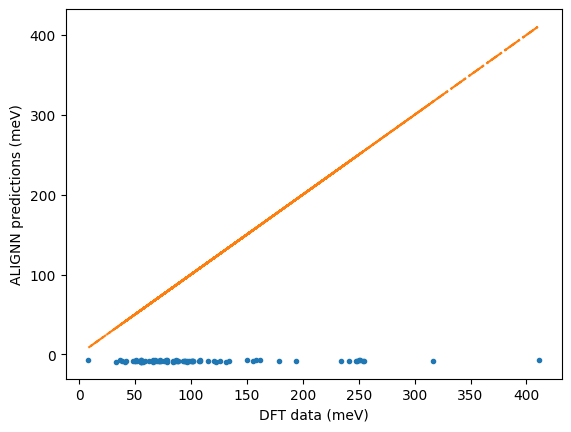

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(df['target'],df['prediction'],'.')
plt.plot(df['target'],df['target'],'-.')
plt.xlabel('DFT data (meV)')
plt.ylabel('ALIGNN predictions (meV)')

In [30]:
# from jarvis.db.figshare import data as jdata
# from jarvis.core.atoms import Atoms
# import os

# temp_dir_name = "DataDir_QM9_U0"
# os.makedirs(temp_dir_name)
# os.chdir(temp_dir_name)

# dft_3d = jdata("qm9_std_jctc") #jdata("dft_3d")
# prop = "U0" #"exfoliation_energy" #"optb88vdw_bandgap"
# f = open("id_prop.csv", "w")
# # count = 0
# for i in dft_3d:
#     atoms = Atoms.from_dict(i["atoms"])
#     jid = i["id"]
#     poscar_name = "POSCAR-" + jid + ".vasp"
#     target = i[prop]
#     if target != "na":
#         atoms.write_poscar(poscar_name)
#         f.write("%s,%6f\n" % (poscar_name, target))
#         # count += 1
#         # if count == max_samples:
#         #     break
# f.close()

# os.chdir(cwd)

In [31]:
pwd

'/content/alignn'

In [32]:
!ls

alignn	       DataDir_ExfoEnergy  LICENSE.rst	opt.traj	README.md  temp
alignn_ff.log  ExfoEnOut	   opt.log	pyproject.toml	setup.py


Changing the cut-off in config_example.json as 5,  n_train as 110000, n_val as 10000, n_test as 10829

In [33]:
# from jarvis.db.jsonutils import loadjson, dumpjson
# config = loadjson("alignn/examples/sample_data/config_example.json")
# config['cutoff'] = 5.0
# config['n_train'] = 110000
# config['n_val'] = 10000
# config['n_test'] = 10829
# dumpjson(data=config, filename="config_qm9.json")

Run for 1000 epochs instead of 5 here to get reasonable performance/MAE

In [34]:
# import time
# t1=time.time()
# !train_folder.py --root_dir "DataDir_QM9_U0" --epochs 5 --batch_size 64 --config "config_qm9.json" --output_dir="DataDir_QM9U0out"
# t2=time.time()
# print ('Time in s',t2-t1)

# 7: Add results to JARVIS-Leaderboard


Checkout the notebook: https://colab.research.google.com/github/knc6/jarvis-tools-notebooks/blob/master/jarvis-tools-notebooks/alignn_jarvis_leaderboard.ipynb

In [35]:
!pip freeze

absl-py==1.4.0
accelerate==0.21.0
aiohttp==3.8.4
aiosignal==1.3.1
alabaster==0.7.13
albumentations==1.2.1
alignn==2023.7.10
altair==4.2.2
anyio==3.7.1
appdirs==1.4.4
argon2-cffi==21.3.0
argon2-cffi-bindings==21.2.0
array-record==0.4.0
arviz==0.15.1
ase==3.22.1
astropy==5.2.2
astunparse==1.6.3
async-timeout==4.0.2
attrs==23.1.0
audioread==3.0.0
autograd==1.6.2
autopep8==2.0.2
Babel==2.12.1
backcall==0.2.0
beautifulsoup4==4.11.2
bleach==6.0.0
blinker==1.4
blis==0.7.9
blosc2==2.0.0
bokeh==2.4.3
branca==0.6.0
build==0.10.0
CacheControl==0.13.1
cachetools==5.3.1
catalogue==2.0.8
certifi==2023.5.7
cffi==1.15.1
chardet==4.0.0
charset-normalizer==2.0.12
chex==0.1.7
click==8.1.6
click-plugins==1.1.1
cligj==0.7.2
cloudpickle==2.2.1
cmake==3.25.2
cmdstanpy==1.1.0
colorcet==3.0.1
colorlover==0.3.0
community==1.0.0b1
confection==0.1.0
cons==0.4.6
contextlib2==21.6.0
contourpy==1.1.0
convertdate==2.4.0
cryptography==3.4.8
cufflinks==0.17.3
cupy-cuda11x==11.0.0
cvxopt==1.3.1
cvxpy==1.3.2
cycler==0.11